<a href="https://colab.research.google.com/github/anaguilarar/rf_interpolation/blob/main/Ejemplo_interpolacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
install.packages("libgeos")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
system('sudo add-apt-repository ppa:ubuntugis/ubuntugis-unstable')
system('sudo apt-get update')
system('sudo apt-get install libudunits2-dev')

In [3]:
install.packages("units")
install.packages("aqp")
install.packages("gstat")
install.packages('plotKML')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [8]:
install.packages("GSIF", repos=c("http://R-Forge.R-project.org"), type = "source")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [10]:
install.packages("ranger")
install.packages("tidyverse")
install.packages("cubelyr")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [9]:
library(tidyverse)
library(raster)
library(rgdal)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.1     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: sp


Attaching package: ‘raster’


The following object is masked from ‘package:dplyr’:

    select


The following object is masked from ‘package:tidyr’:

    extract


rgdal: version: 1.5-24, (SVN revision (unknown))
Geospatial Data Abstraction Library extensions to R successfully loaded
Loaded GDAL runtime: GDAL 2.2.3, released 2017/11/20
Path to GDAL shared files: /usr/share/gdal/2.2
GDAL binary built with GEOS: TRUE 
Loaded PROJ runtime: Rel. 4.9.3, 15 August 2016, [PJ_VERSION

In [14]:
###https://github.com/imbs-hl/ranger
library(ranger)

library(gstat)
library(sp)
library(cubelyr)
## http://gsif.r-forge.r-project.org/
library(GSIF)

GSIF version 0.5-5 (2019-01-04)

URL: http://gsif.r-forge.r-project.org/



In [62]:
from_sppixel_toraster = function(rast, sppixel){
  
  rast[] = NaN
  coords = raster::coordinates(sppixel)
  posraster = raster::cellFromXY(rast, coords)
  
  rast[posraster] = sppixel[[1]]
  
  return(rast)
}


## Interpolación espacial con Random Forest

El presente código tiene como finalidad, el poder interpolar datos espaciales utilizando Random Forest. Para mayor información de la métodología, consultar [Sekulic, et al, 2020](https://www.mdpi.com/2072-4292/12/10/1687/htm).

### Configuración de los datos de entrada

Como primer paso se leeran las bases de datos, para este ejercicio son necesarias cuatro:
 * Capa raster de referencia (ser'a usado para conocer la grilla para la interpolación)
 * Información de grilla de suelos en formato csv
 * Capa de elevación de la región
 * Archivo vector del área de interés (opcional si es necesario hacer algún recorte a alguna capa raster)

In [20]:
download.file(url = "https://github.com/anaguilarar/rf_interpolation/archive/refs/heads/main.zip"
                                   , destfile = "data.zip")
unzip(zipfile = "data.zip")

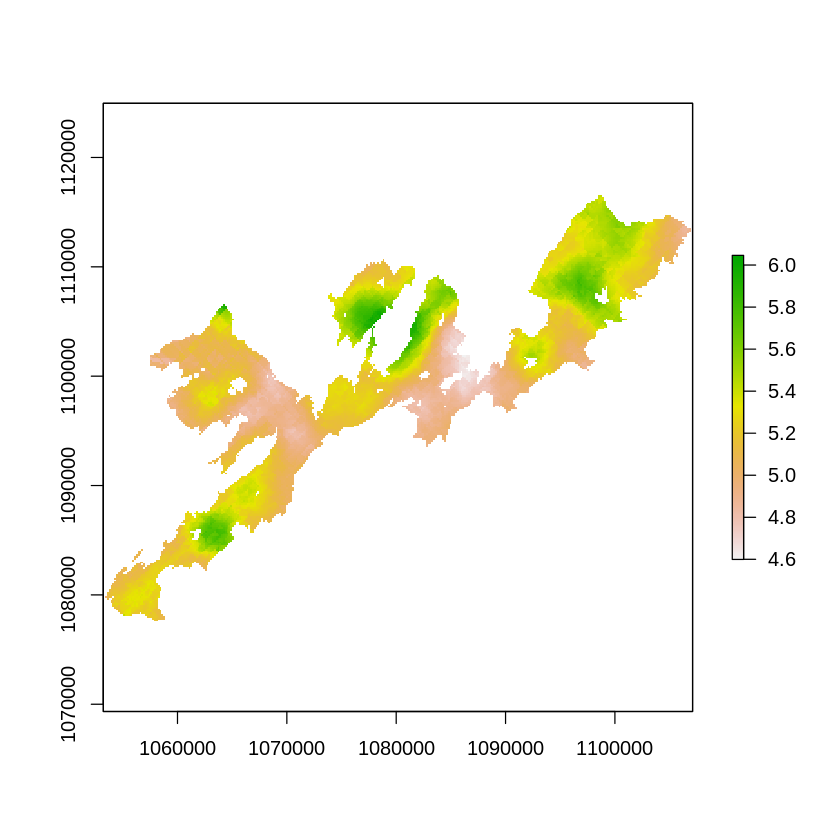

In [23]:
### raster de referencia
rasterref = raster("/content/rf_interpolation-main/data/pH.tif")
plot(rasterref)

In [27]:
### Leer datos de suelo
soildata = readr::read_csv("/content/rf_interpolation-main/data/Copy of Suelos_600muestras_N_CO.csv")



── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  ID = col_character(),
  ID_PUNTOS = col_character(),
  GUIA = col_character(),
  OBSER = col_logical(),
  TEXTURA = col_character(),
  Al_3 = col_character(),
  B = col_character()
)
ℹ Use `spec()` for the full column specifications.




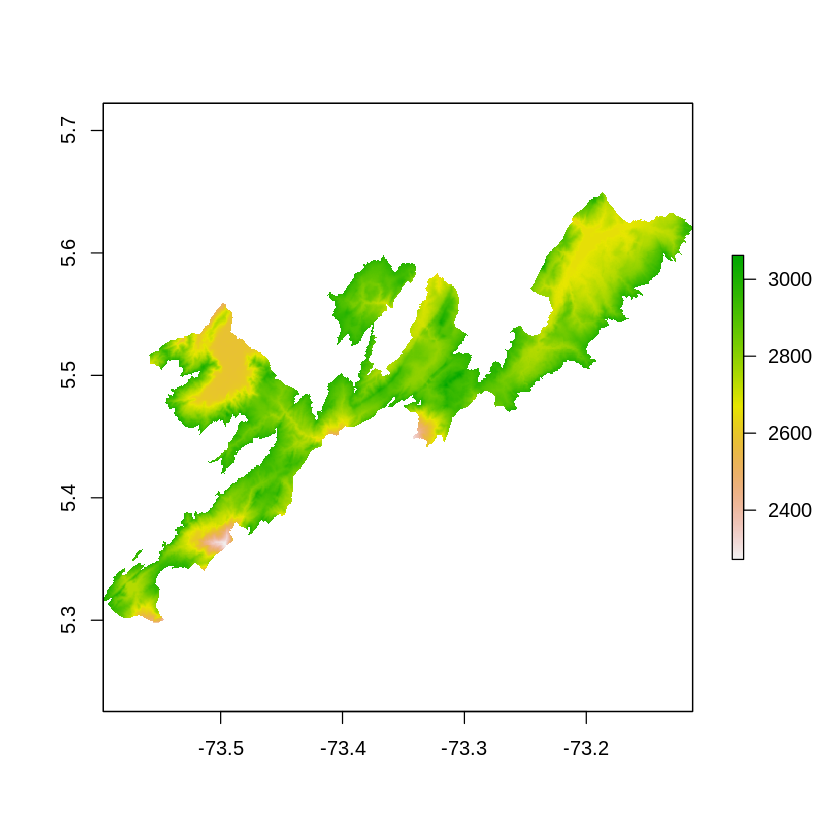

In [25]:
### capa de elevación digital

dem = raster("/content/rf_interpolation-main/data/dem_boyaca_c.tif")
plot(dem)

Una vez los datos de suelos son leidos, se transforman a formato de puntos espaciales, para ello es necesario contar con la tabla de suelo y la proyección de las coordenadas(en este caso WGS84). Estos puntos serán reproyectados a el sistema de coordendas del raster de referencia.

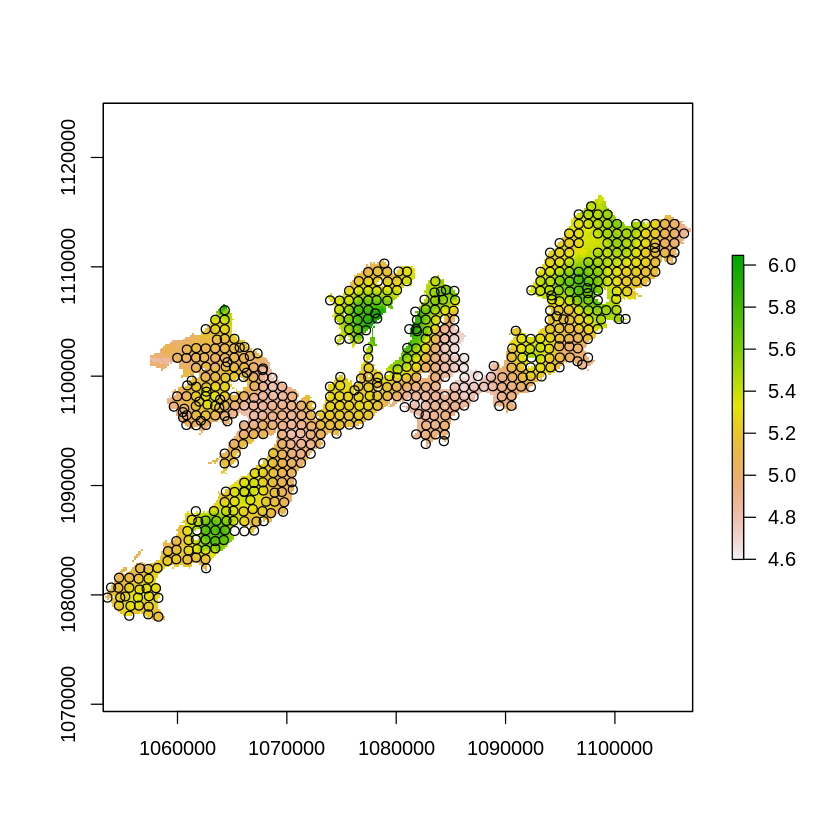

In [29]:
### convertirlos a spatial points
spdf <- SpatialPointsDataFrame(coords = cbind(soildata$Long, soildata$Lati), data = soildata,
                               proj4string = CRS("+proj=longlat +datum=WGS84 +ellps=WGS84 +towgs84=0,0,0"))

### proyección

spdf = spTransform(spdf, crs(rasterref))
plot(rasterref)
points(spdf)

Uno de los requesitos para trabajar con el algoritmo propuesto, es convertir el archivo refrencia en formato SpatialPixelDataframe, de la libreria raster.Por lo que el raster de referencia, primero se convierte en una tabla de puntos para luego ser transformado en pixels.

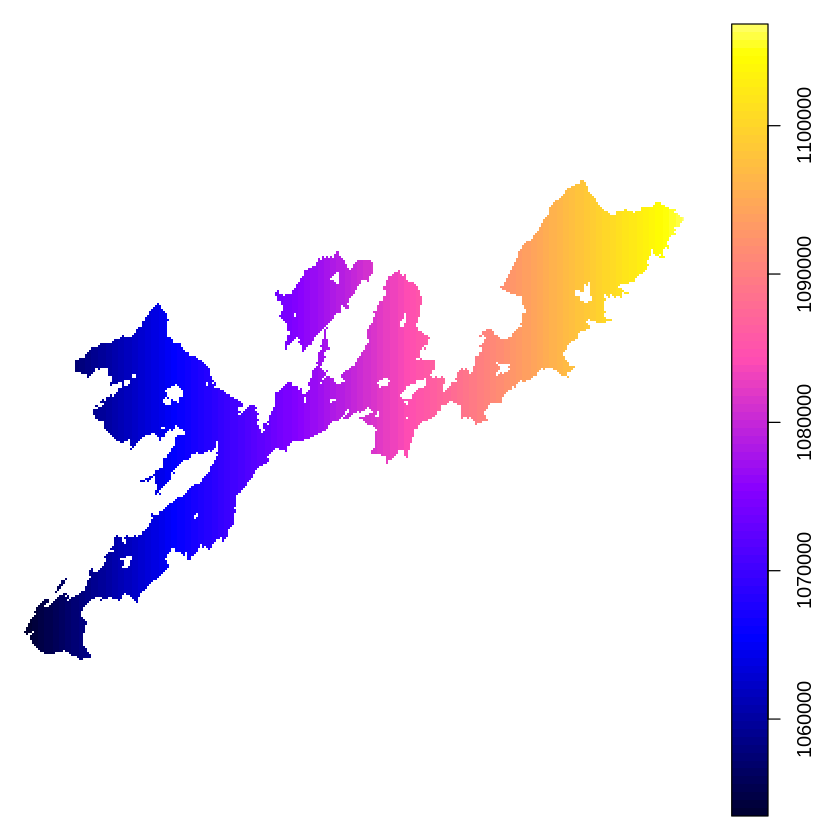

In [30]:

###### convertir raster de referencia a spatial pixel dataframe


dataroi = data.frame(coordinates(rasterref)[!is.na(values(rasterref)),])
dataroi$id = 1:nrow(dataroi)

sppixelsroi = SpatialPixelsDataFrame(
  SpatialPixels(
    SpatialPoints(
      coordinates(rasterref)[!is.na(values(rasterref)),])), data = dataroi)

crs(sppixelsroi) = crs(rasterref)

plot(sppixelsroi)

Paso siguiente es la de agregar covariables que puedan ayudar al desempeño del modelo, en este caso se utilizaran dos la elevción y la pendiente. estos serán calculados del dem. Luego se utilizarán los pixeles referencia para extraer estos valores.

In [32]:
## añadir covariables

dem_reprojected = projectRaster(dem, crs = crs(rasterref))
slope = terrain(dem_reprojected, 'slope', unit='degrees', neighbors=8)

slopepoints = raster::extract(slope,sppixelsroi@coords)
dempoints = raster::extract(dem_reprojected,sppixelsroi@coords)

sppixelsroi$dem = dempoints
sppixelsroi$slope = slopepoints

Converting covariates to principal components...



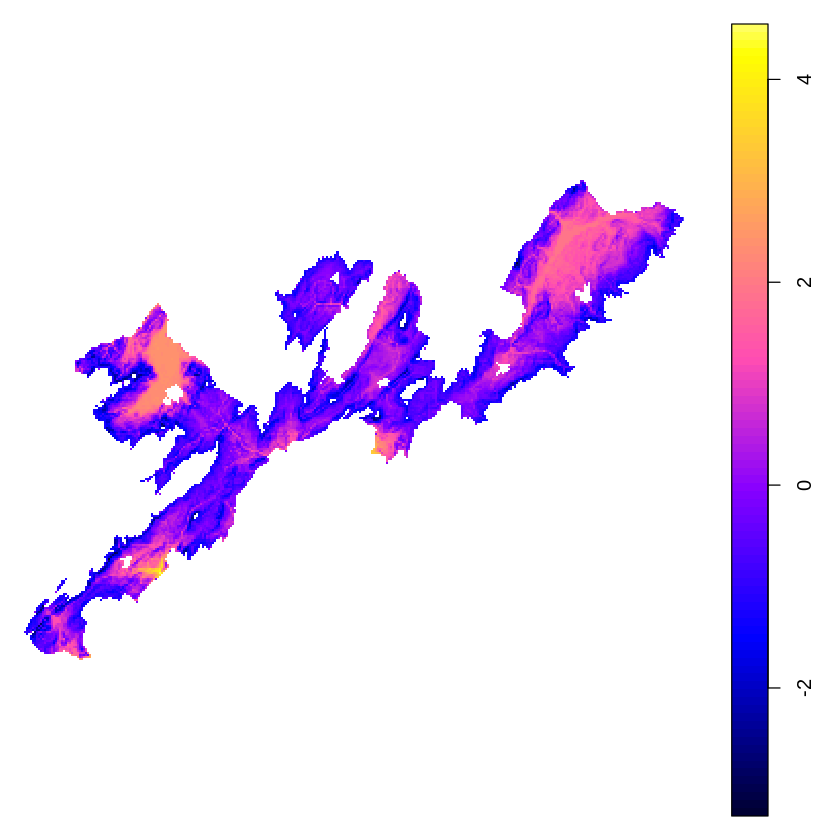

In [33]:
## reducir con pca

grids.spc = GSIF::spc(sppixelsroi, as.formula("~ dem  + slope "))
plot(grids.spc@predicted[1])

In [34]:
variable = "pH"

### Obtención de las capas de distancia

Para conocer la correlación espacial entre las observaciones, es necesario conocer las distancias entre cada punto y sus n vecinos más cercanos, estas distancias luego serán incluidas como covariables del modelo.

![GitHub Logo](https://www.mdpi.com/remotesensing/remotesensing-12-01687/article_deploy/html/images/remotesensing-12-01687-g001.png =100x20)


In [35]:
grid.dist_soil <- GSIF::buffer.dist(spdf[,variable], 
                                      sppixelsroi[1], as.factor(1:nrow(spdf)))

crs(grid.dist_soil) = crs(spdf)

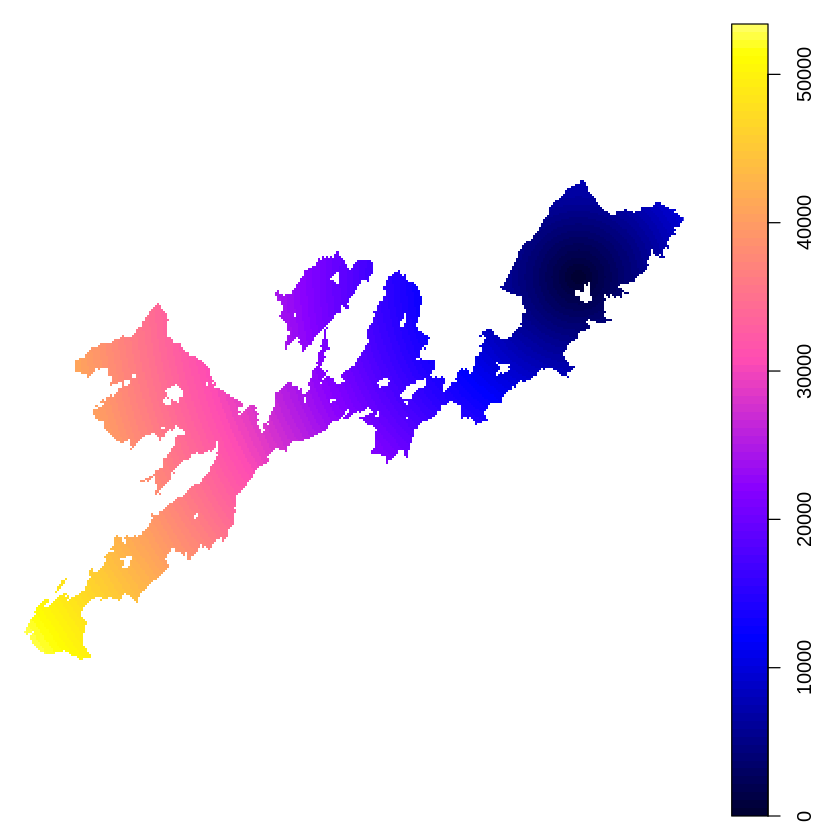

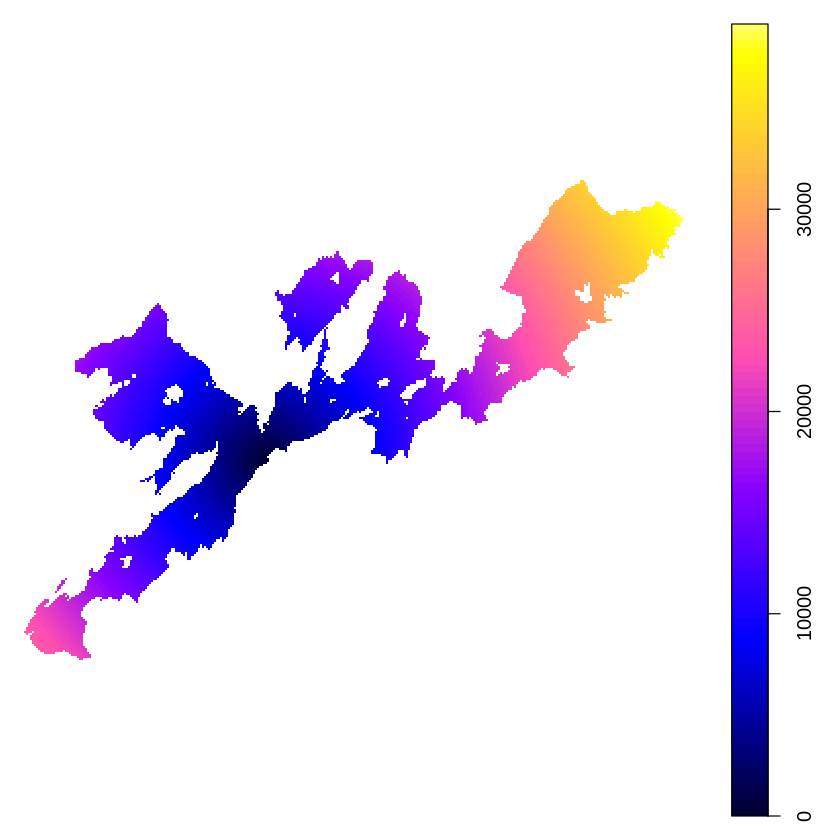

In [59]:
for(i in c(1, 200)){
  plot(grid.dist_soil[i])
}

### Configurando el modelo

Una vez se cuenta con todas las variables se procede a definir la ecuación que se utilizara en el modelo Random Forest, unir las bases de datos de entrenemaiento y por tultimo definir el modelo.

In [48]:
### definición de la formula de entrada con todas las variables
dn0 = paste(names(grid.dist_soil), collapse="+")

fm1 = as.formula(paste(variable," ~ ", dn0, " + ", 
                        paste(names(grids.spc@predicted), collapse = "+")))
fm1

pH ~ layer.1 + layer.2 + layer.3 + layer.4 + layer.5 + layer.6 + 
    layer.7 + layer.8 + layer.9 + layer.10 + layer.11 + layer.12 + 
    layer.13 + layer.14 + layer.15 + layer.16 + layer.17 + layer.18 + 
    layer.19 + layer.20 + layer.21 + layer.22 + layer.23 + layer.24 + 
    layer.25 + layer.26 + layer.27 + layer.28 + layer.29 + layer.30 + 
    layer.31 + layer.32 + layer.33 + layer.34 + layer.35 + layer.36 + 
    layer.37 + layer.38 + layer.39 + layer.40 + layer.41 + layer.42 + 
    layer.43 + layer.44 + layer.45 + layer.46 + layer.47 + layer.48 + 
    layer.49 + layer.50 + layer.51 + layer.52 + layer.53 + layer.54 + 
    layer.55 + layer.56 + layer.57 + layer.58 + layer.59 + layer.60 + 
    layer.61 + layer.62 + layer.63 + layer.64 + layer.65 + layer.66 + 
    layer.67 + layer.68 + layer.69 + layer.70 + layer.71 + layer.72 + 
    layer.73 + layer.74 + layer.75 + layer.76 + layer.77 + layer.78 + 
    layer.79 + layer.80 + layer.81 + layer.82 + layer.83 + layer.84 + 
    layer.85 +

In [50]:
## unión de las bases de datos

ov.distances = over(spdf[variable], grid.dist_soil)
ov.covar = over(spdf[variable], grids.spc@predicted)

rm_data = do.call(cbind, list(spdf@data[variable], ov.distances , ov.covar))
## quitar nas
rm_data = rm_data %>% na.omit()

head(rm_data)

,pH,layer.1,layer.2,layer.3,layer.4,layer.5,layer.6,layer.7,layer.8,layer.9,⋯,layer.593,layer.594,layer.595,layer.596,layer.597,layer.598,layer.599,layer.600,PC1,PC2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,5.73,0.0000,994.8073,1823.813,2652.819,3481.8254,4476.6328,5206.264,4389.820,3579.156,⋯,5139.837,4310.832,3481.825,2487.018,1666.282,829.006,7741.336,8701.01,1.4950918,-0.6919693
2,5.66,994.8073,0.0000,829.006,1658.012,2487.0181,3481.8254,6190.405,5370.014,4552.746,⋯,6134.645,5305.639,4476.633,3481.825,2657.996,1823.813,7972.263,9567.75,0.8773066,-0.5558518
3,5.43,1823.8134,829.0060,0.000,829.006,1658.0121,2652.8193,7012.823,6190.405,5370.014,⋯,6963.651,6134.645,5305.639,4310.832,3485.771,2652.819,8251.838,10307.72,-0.1104920,0.0904160
4,4.92,2652.8193,1658.0121,829.006,0.000,829.0060,1823.8134,7836.629,7012.823,6190.405,⋯,7792.657,6963.651,6134.645,5139.837,4314.019,3481.825,8602.511,11060.32,-0.4960208,-0.1665609
5,4.97,3481.8254,2487.0181,1658.012,829.006,0.0000,994.8073,8661.428,7836.629,7012.823,⋯,8621.663,7792.657,6963.651,5968.844,5142.511,4310.832,9015.989,11823.15,-0.7122369,-0.6167761
6,5.21,4476.6328,3481.8254,2652.819,1823.813,994.8073,0.0000,9652.137,8826.481,8001.519,⋯,9616.471,8787.464,7958.458,6963.651,6136.885,5305.639,9583.539,12749.46,-1.2120778,-0.4679209


In [53]:
### definición del modelo Random Forest

rf_model = ranger(fm1, rm_data, importance="impurity", 
                       quantreg=TRUE, num.trees=600, seed=123)

rf_model

Ranger result

Call:
 ranger(fm1, rm_data, importance = "impurity", quantreg = TRUE,      num.trees = 600, seed = 123) 

Type:                             Regression 
Number of trees:                  600 
Sample size:                      585 
Number of independent variables:  602 
Mtry:                             24 
Target node size:                 5 
Variable importance mode:         impurity 
Splitrule:                        variance 
OOB prediction error (MSE):       0.3182565 
R squared (OOB):                  0.09374211 

In [ ]:
###

### Interpolación utilizando el modelo entrenado

Para interpolar, se utiliza la grilla de puntos del mapa de referencia. Primero se unen las varaibles, luego se definen unos quantiles para conocer que tan disperso es el resultado de la predicción.

In [55]:
### uniendo las bases de datos de las distancias con las covariables
datatopredict = grid.dist_soil@data
  
for(i in names(grids.spc@predicted)){
  datatopredict[[i]] = grids.spc@predicted[[i]]
}

In [60]:
quantiles = c((1-.682)/2, 0.5, 1-(1-.682)/2)

soil_inter_values =  predict(rf_model, datatopredict, 
                         type="quantiles", quantiles=quantiles)$predictions

### Exportar los datos como geo raster

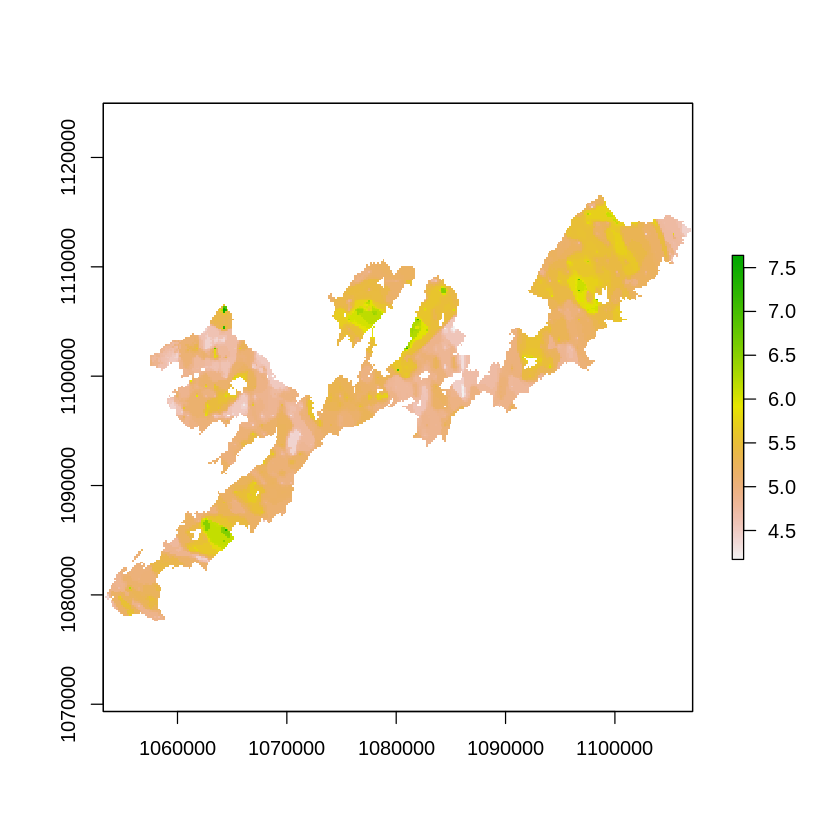

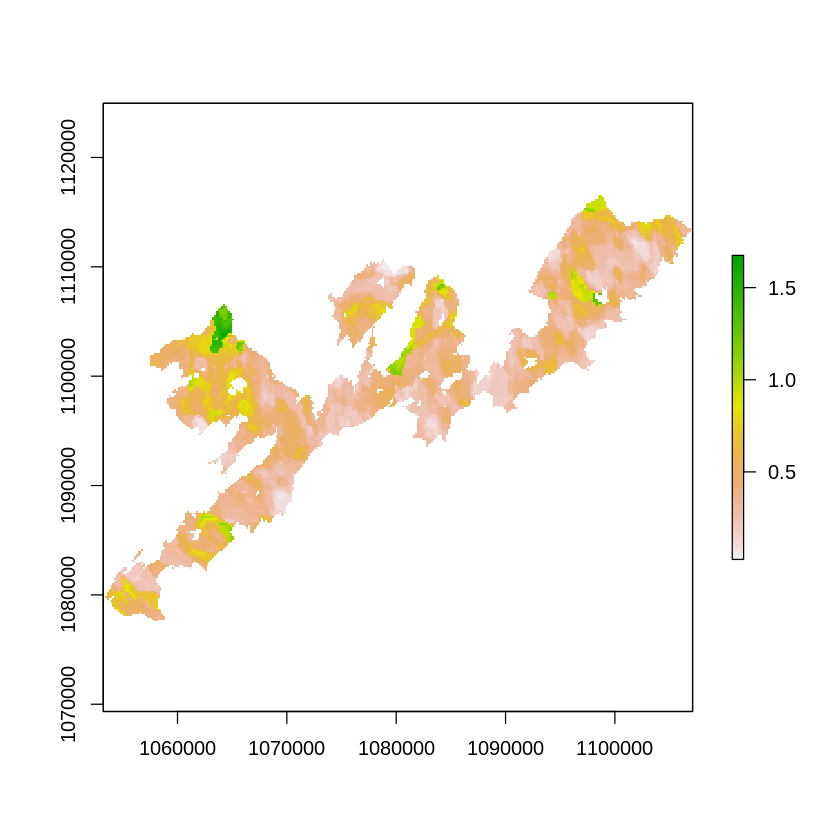

In [64]:
sppixel_temp = grid.dist_soil
  
sppixel_temp[[1]] = soil_inter_values[,2]
soilinter = from_sppixel_toraster(rasterref, sppixel_temp)
raster::plot(soilinter)

sppixel_temp[[1]] = (soil_inter_values[,3]-soil_inter_values[,1])/2
soilinter_error = from_sppixel_toraster(rasterref, sppixel_temp)
raster::plot(soilinter_error)

writeRaster(stack(list(soilinter, soilinter_error)), 
              paste0("/content/",variable,"_rfcovar.tif"), format = "GTiff", overwrite=TRUE)